###Connecting to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
path_to_folder = "ENPM673/tutorials/"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/tutorials


###Importing Dependencies

In [3]:
# Importing Dependencies
import cv2
import numpy as np
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

###Intializing Varibles

In [4]:
# cent_arr will store the centroid coordinates
cent_arr =np.array([0,0])

# my_frame will store 500th frame
my_frame =np.array([0,0,0])

# token is used to track number of frames executed
token = 0

###Capturing Video

In [5]:
# Read a video
video_capture = cv2.VideoCapture("assets/object_tracking.mp4")

# Get video properties
frame_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.mp4', fourcc, 193, (frame_width, frame_height))

###Loop over each frame to extract the pixels of moving object

* Store individual frames in each iteration of the loop using cap.read(). In this frame we will track the black object
* Grabe 500th frame and store it in my_frame. It will be used later to in the plot.
* Using cvt.Color() we convert our frame in BRG format to Grayscale. This will significantly increase the contrast between the object and its background.
* Store the coordinates of pixels which have value than 10. As the object is not completely black its pixel value has been observed to range between 0 to 10.
* Calculate the minimum and maximum coordinates of the object and calculate centroid.
* Store these centroid coordinates in cent_arr
* Using centroid as the center we can plot solid circle in the frame. This used to track the black object.


In [6]:
while(True):
	#Storing individual frames in each loop iteration
	ret, frame = video_capture.read()

	#Terminate the loop if frame not captured from the video
	if not ret:
		break

	#Using token to track the number of frames/loops extecuted
	token = token+1

	#Grabbing 500th frame and storing in my_frame
	if token == 500:
		my_frame = frame

	#Converting frames from BGR to Grayscale
	gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

	#Initializing my_arr in every iteration of loop
	my_arr = np.array([[0, 0]])

	#Finding rows and col of black pixels
	row, col = np.where(gray_frame < 10)
	my_arr = np.column_stack((row, col))

	#Calculating centroid
	if my_arr.size > 0:
		min_x = np.min(my_arr[1:,1])
		min_y =	np.min(my_arr[1:,0])
		max_x = np.max(my_arr[1:,1])
		max_y =	np.max(my_arr[1:,0])

		#Centroid(x,y)
		centroid = 	np.array([min_x +((max_x - min_x)//2),min_y+((max_y - min_y)//2)])

		#Storing centroid values of each frame
		cent_arr = np.vstack((cent_arr,centroid))

		#Plotting Circle
		orign = (centroid[0],centroid[1])
		frame = cv2.circle(frame,orign, 10, (0, 0, 255),-1)

		# Writing the frame to the output video. Uncomment the following command when video needs to be displayed
		# out.write(frame)

  #wait for 1 ms so that frames can be processed. In case 'q' key is pressed terminated the loop
	ch = cv2.waitKey(1)
	if ch & 0xFF == ord('q'):
		break


video_capture.release()
# out.release()
cv2.destroyAllWindows()

### Displaying Video
Uncomment the following block to to **Display Video**\
Then uncomment
* out.write(frame)
* video_capture.release()\
command in the cell above


In [7]:
# import imageio
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# from skimage.transform import resize
# from IPython.display import HTML

# # Function to display the video
# def display_video(video):
#     fig = plt.figure(figsize=(3,3))

#     mov = []
#     for i in range(len(video)):
#         img = plt.imshow(video[i], animated=True)
#         plt.axis('off')
#         mov.append([img])

#     #Animation creation
#     anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)
#     plt.close()

#     return anime

# # Load video
# video = imageio.mimread('output_video.mp4', memtest=False)

# # Size adjustment (if necessary)
# # video = [resize(frame, (256, 256))[..., :3] for frame in video]

# # Inline video display in HTML5
# HTML(display_video(video).to_html5_video())

##Graph fitting
Now that we have coordinates for centroid for all frames, we will employ ‘Standard Least Square’ to fit a parabola through the found centroids.

Equation of parabola :   $y = ax^2 + bx + c$

We can write the above equation in matrix form : Ax=B\
where,\
A = $\begin{bmatrix}
x_n^2 & x_n & 1
\end{bmatrix}$

x =
$\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}$

B = $[y_n]$

We have have the values for $x_n$ and $y_n$, so we need to calculate $\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}$ to get the equation of parabola\
Since matrix A is non square matrix $ A^{-1} $ does not exist, so
</br>

*   Pre-Multiply $A^T$\
$(A^T A) \cdot \mathbf{x} = A^T \mathbf{B}$
</br>

*   Pre-Mutilpy by $(A^T A)^{-1}$\
$\mathbf{x} = (A^T A)^{-1} A^T \mathbf{B}$




















In [13]:

# Matrix A
A = np.column_stack([cent_arr[:, 0] ** 2, cent_arr[:, 0], np.ones(len(cent_arr))])

# Vector B
B = cent_arr[:, 1]

# Calculating A transpose
A_t = np.transpose(A)

# Calculating (A tanspose)*B
A_t_B = np.matmul(A_t, B)

# Calculating (A transpose)*A
A_t_A = np.matmul(A_t,A)

# Calculating inverse((A transpose)*A)
inv_A_t_A = np.linalg.inv(A_t_A)

# Solving the equation inverse((A transpose)*A)*((A tanspose)*B)
B = np.matmul(inv_A_t_A,A_t_B)

#Coefficients of Parabola equation
a, b, c = tuple(B)


###Finding y axis value for given x axis

We will just the value of x in the equation $y = ax^2 + bx + c$

In [14]:
x = 1000
y = a*x**2 + b*x + c
print(y)

389.4477818730593


###Plotting Parabola


* Create an evenly spaced numpy array in the range $x_1$ to $x_n$
* Input these values in equation  $y = ax^2 + bx + c$ and the store the result in variable y
* Plot the these x & y points on a graph
* Plot centroid obtained earlier in the same window as scatter plot
* Display the 500th frame in the same window






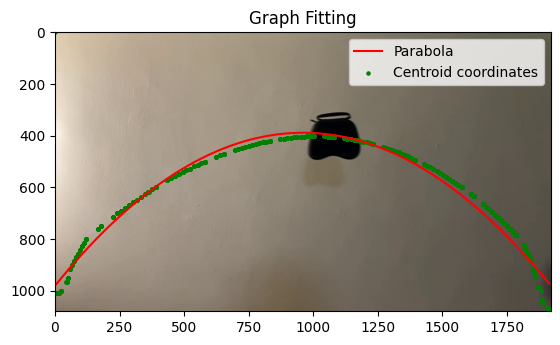

In [16]:
# Plotting parabola

x = np.linspace(cent_arr[0, 0], cent_arr[-1, 0], 1000)

y = a * x**2 + b * x + c

plt.plot(x,y,color='r')

# Scatter plot
plt.scatter(cent_arr[:,0],cent_arr[:,1],c ="green",s=5)

#Displaying 500th frame
my_frame = cv2.cvtColor(my_frame,cv2.COLOR_BGR2RGB)

plt.title('Graph Fitting')

plt.legend(["Parabola", "Centroid coordinates"])

plt.imshow(my_frame)

plt.show()
